## Pipeline for House Price Prediction

## Introduction
[Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/) helps with building entire workflows

These steps can be triggered automatically by a CI/CD workflow or on demand from a command line or notebook.


**Components** performs a single step in a Machine Learning workflow such (e.g. data ingestion, data preprocessing, data transformation, model training, hyperparameter tuning). 


### Problem Statement
Acquiring properties is common in our society today. However, a guildline for interested/prospected buyers to help them get a good value for their money seems to be lacking and buyers are left at their fate to gamble different options with their hard earned money. This project seeks to provide a model to guide buyers predict the price of a house based on their choices' features of a house.

### Data:
The data was collected within the 3 months, the feautures include city, number of bedrooms, number of bathrooms, square of living area, square of basement, number of floors, waterfront, number of views, year built, year renovated, etc

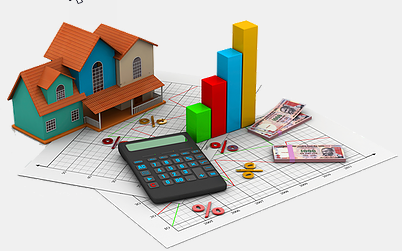
## Prerequisites
check to see if kfp is installed:

In [ ]:
# You may need to restart your notebook kernel after updating the kfp sdk
! pip3 show kfp

## 1. Configure access Minio 

### Upload our Training Dataset to Minio

First, we configure credentials for `mc`, the MinIO command line client.
We then use it to create a bucket, upload the dataset to it, and set access policy so that the pipeline can download it from MinIO.

Follow the steps below to download minio client
<div class="alert">
   <code>
    wget https://dl.min.io/client/mc/release/linux-amd64/mc
    chmod +x mc
    ./mc --help
    </code>

</div>

In [ ]:
! wget https://dl.min.io/client/mc/release/linux-amd64/mc
! chmod +x mc
! ./mc --help

#### a. Connect to the Minio Server

In [ ]:
! ./mc alias set minio http://minio-service.kubeflow:9000 minio minio123

#### b. Create a bucket to store your data and export your model to Minio

**Make sure you clear this bucket once you are cone running your pipeline**

In [ ]:
! ./mc mb minio/house

#### c. Upload the dataset to your bucket in Minio.

**Note**: Make sure you have your dataset in a folder like we have here as <code>datasets</code>.

In [ ]:
! tar --dereference -czf datasets.tar.gz ./datasets
! ./mc cp datasets.tar.gz minio/house/datasets.tar.gz
! ./mc policy set download minio/house

### If you have downloaded your data too many times while testing, use the following code to clear out your bucket

In [ ]:
# ! ./mc rm --recursive --force minio/house

### Minio Server URL and Credentials

In [ ]:
MINIO_SERVER='minio-service.kubeflow:9000'
MINIO_ACCESS_KEY='minio'
MINIO_SECRET_KEY='minio123'

## How to Implement Kubeflow Pipelines Components

In this pipeline, we have the following components:
- House price dataset download component
- Preprocess the dataset component
- Train the model component
- Make predictions component
- Export the trained model component

In [ ]:
from typing import NamedTuple
import kfp
import kfp.components as components
import kfp.dsl as dsl
from kfp.components import InputPath, OutputPath #helps define the input & output between the components

### Component 1: Download the Data Set

In [ ]:
def download_dataset(minio_server: str, data_dir: OutputPath(str)):
    """Download the data set to the KFP volume to share it among all steps"""
    import urllib.request
    import tarfile
    import os
    import subprocess

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    url = f'http://{minio_server}/house/datasets.tar.gz'
    print(url)
    stream = urllib.request.urlopen(url)
    print('done downloading')
    tar = tarfile.open(fileobj=stream, mode="r|gz")
    tar.extractall(path=data_dir)
    print('done extracting')
    
    
    subprocess.call(["ls", "-dlha", data_dir])
    

### Component 2: Preprocess Dataset

In [ ]:
def preprocess(data_dir: InputPath(str), clean_data_dir: OutputPath(str)):
    
    import numpy as np
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
    from sklearn.model_selection import KFold
    from sklearn.model_selection import train_test_split  # splitting the data
    import pandas as pd
    import pickle
    import os
    
    # Get data
    
    data = pd.read_csv(f"{data_dir}/datasets/data.csv")
    
    #print(data)
    
    data.drop(columns=['country', 'statezip', 'street'], inplace=True)
    #Filtering for prices that are not zero.
    data = data.query('price != 0')
    
    #Filtering for houses not zero for number of bedrooms and bathrooms
    data = data.query('bedrooms != 0' or 'bathrooms != 0')
    
    
    
    # Converting the city variable to numerical values.
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    data["city"] = le.fit_transform(data["city"])
    
    #year convert function
    def yr_col (col1, col2):
        if col1 == 0:
            col1 = col2
        else:
            col1
        return col1
    
#     data.drop(columns=['yr_renovated'], inplace=True)
#     Change year renovated column with zero entry to the year built.
    data['yr_renovated'] = data.apply(lambda x: yr_col(x['yr_renovated'], x['yr_built']), axis =1)
    
    #Filtering the outliers
    data = data[(
                (data["price"] <= 2000000) & 
                (data["price"] > 150000) & 
                (data["bathrooms"] <= 4.5) & 
                (data["condition"] > 2) & 
                (data["sqft_living"] > 700) & 
                (data["sqft_living"] <= 5000) & 
                (data["sqft_lot"] <= 50000) & 
                (data["sqft_above"] <= 5000) &
                (data["sqft_basement"] <= 5000) &
                (data["bedrooms"] <= 6) )]
    
    #Filtering for multicollinearity
    data = data.drop(columns=['sqft_living', 'sqft_above'])
    
    print(data)
    # We normalise our dataset to a common scale using the min max scaler
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    # split the data into X and y
    X = data.drop(['price'], axis=1)  # predictor
    y = data.loc[:,'price'] # target
    
    # Split the data into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    
    data = {"X_train": X_train,"X_test": X_test, "y_train": y_train,"y_test": y_test}
    
    os.makedirs(clean_data_dir, exist_ok=True)

    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'wb') as f:
        pickle.dump(data, f)
    
    print(f"clean_data.pickle {clean_data_dir}")
    
    print(os.listdir(clean_data_dir))
    
    print("Preprocessing Done")

## Component 3: Training the data with the Catboost Regressor

In [ ]:
def train_model(clean_data_dir: InputPath(str), model_dir: OutputPath(str)):
    
    # Install all the dependencies inside the function
    import numpy as np
    import pickle
    import os
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'catboost==0.24.2'])
    import pandas as pd
    # import libraries for training
    from catboost import CatBoostRegressor
    
    #load the preprocessed data
    
    print(clean_data_dir)
    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'rb') as f:
        data = pickle.load(f)
        
    print(data)
    
    X_train = data['X_train']
    y_train = data['y_train']
    
    # Instantiating the model 
    model = CatBoostRegressor(verbose=1, n_estimators=10)
    
    # Fit the model to the training data
    model.fit(X_train,y_train)
    
    #Save the model to the designated 
    os.makedirs(model_dir, exist_ok=True)
    
    with open(os.path.join(model_dir,'model.pickle'), 'wb') as f:
        pickle.dump(model, f)
    
    print(f"model.pickle {model_dir}")
    
    print(os.listdir(model_dir))

## Component 4: Make Predictions

In [ ]:
def prediction(
    clean_data_dir: InputPath(str), model_dir: InputPath(str), metrics_path: OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):   
    import pickle
    import os
    import sys, subprocess;
    import numpy as np
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'catboost==0.24.2'])
    # Evaluation metrics
    from sklearn.metrics import mean_squared_error, r2_score
    from collections import namedtuple
    import json
    print(model_dir)
    with open(os.path.join(model_dir,'model.pickle'), 'rb') as f:
        model = pickle.load(f)        
    print(model)
    
    print(clean_data_dir)
    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'rb') as f:
        data = pickle.load(f)       
    print(data)
 
    X_test = data['X_test']
    y_test = data['y_test']
    X_train = data['X_train']
    y_train = data['y_train']
    
    #Evaluate the model and print the results
    model_pred = model.predict(X_test)
    
    
    r2_score = r2_score(y_test, model_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, model_pred))
    rmse_train=np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    
    metrics = {
        "metrics": [
            {"name": "r2_score", "numberValue": str(r2_score), "format": "PERCENTAGE"},
            {"name": "rmse_test", "numberValue": str(rmse_test), "format": "PERCENTAGE"},
            {"name": "rmse_train", "numberValue": str(rmse_train), "format": "PERCENTAGE"}
            
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))

### Component 5: Export the Model

In [ ]:
def export_model(
    model_dir: InputPath(str),
    metrics: InputPath(str),
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    import os
    import boto3
    from botocore.client import Config

    s3 = boto3.client(
        "s3",
        endpoint_url=f'http://{minio_server}',
        aws_access_key_id=minio_access_key,
        aws_secret_access_key=minio_secret_key,
        config=Config(signature_version="s3v4"),
    )

    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    for root, dirs, files in os.walk(model_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, model_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{model_name}/{model_version}/{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

## Combine the Components into a Pipeline


In [ ]:
def train_model_pipeline(
    data_dir: str,
    clean_data_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mavencodev/minio:v.0.1"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )(minio_server)
    
    preprocessOp = components.func_to_container_op(preprocess, base_image=BASE_IMAGE)(
        downloadOp.output
    )
    trainOp = components.func_to_container_op(train_model, base_image=BASE_IMAGE)(
        preprocessOp.output
    )

    predictionOp = components.func_to_container_op(prediction, base_image=BASE_IMAGE)(
        preprocessOp.output, trainOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        trainOp.output, predictionOp.output, export_bucket, model_name, model_version, 
        minio_server, minio_access_key, minio_secret_key
    )

In [ ]:

def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="End-to-End House Prediction",
    description="A sample pipeline to demonstrate multi-step model training, evaluation and export",
)
def price_prediction_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    clean_data_dir: str= "/train/data",
    export_bucket: str = "house",
    model_name: str = "house",
    model_version: int = 1,
):
    MINIO_SERVER='minio-service.kubeflow:9000'
    MINIO_ACCESS_KEY='minio'
    MINIO_SECRET_KEY='minio123'
    
    train_model_pipeline(
        data_dir=data_dir,
        clean_data_dir=clean_data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
        minio_server=MINIO_SERVER,
        minio_access_key=MINIO_ACCESS_KEY,
        minio_secret_key=MINIO_SECRET_KEY,
    )
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [ ]:
pipeline_func = price_prediction_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End-Demo"

kfp.compiler.Compiler().compile(pipeline_func,  'price_prediction.yaml')
    

#### Upload the generated yaml file to create a pipeline in Kubeflow UI

##### Now delete your bucket when you have run the pipeline successfully in the Kubeflow UI.

In [ ]:
# ! ./mc rb minio/house --force